# Optional Homework 2

In a new python environment with python>=3.10

In [18]:
%%script false --no-raise-error
!pip install "torch_uncertainty[image] @ git+https://github.com/ENSTA-U2IS-AI/torch-uncertainty@dev"

In [19]:
import shutil
import json

import random
import numpy as np

from einops import rearrange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F
from torchvision.utils import draw_segmentation_masks

from torchmetrics.utilities.compute import _safe_divide

from torch_uncertainty.datasets import MUAD
from torch_uncertainty.metrics.classification import MeanIntersectionOverUnion

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [20]:
# Training parameters
batch_size = 10
num_workers = 2
learning_rate = 1e-3
weight_decay = 2e-4
lr_decay_epochs = 20
lr_decay = 0.1
nb_epochs = 50

In [21]:
train_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = v2.Compose(
    [
        v2.Resize(size=(256, 512), antialias=True),
        v2.ToDtype(
            dtype={
                tv_tensors.Image: torch.float32,
                tv_tensors.Mask: torch.int64,
                "others": None,
            },
            scale=True,
        ),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_set = MUAD(root="./data", target_type="semantic", version="small", split="train", transforms=train_transform, download=True)
val_set = MUAD(root="./data", target_type="semantic", version="small", split="val", transforms=val_transform, download=True)
test_set = MUAD(root="./data", target_type="semantic", version="small", split="test", transforms=val_transform, download=True)

Let us see the first sample of the validation set. The first image is the input and the second image is the target (ground truth).

In [22]:
sample = train_set[0]
img, tgt = sample
img.size(), tgt.size()

(torch.Size([3, 256, 512]), torch.Size([1, 256, 512]))

Visualize a validation input sample (and RGB image)

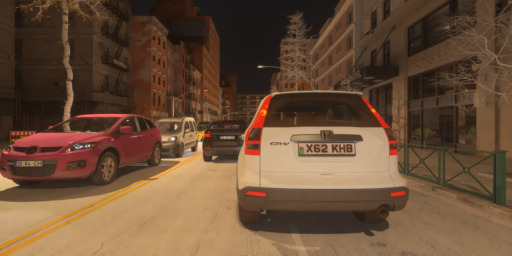

In [23]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)
F.to_pil_image(img)

Visualize the same image above but segmented (our goal)

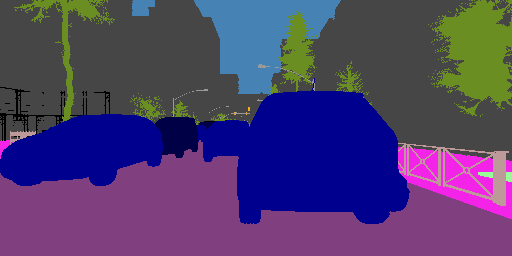

In [24]:
tmp_tgt = tgt.masked_fill(tgt == 255, 21)
tgt_masks = tmp_tgt == torch.arange(22, device=tgt.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, tgt_masks, alpha=1, colors=val_set.color_palette)
F.to_pil_image(img_segmented)

Below is the complete list of classes in MUAD, presented as:

1.   Class Name
2.   Train ID
3.   Segmentation Color in RGB format [R,G, B].

In [25]:
for muad_class in train_set.classes:
    class_name = muad_class.name
    train_id = muad_class.id
    color = muad_class.color
    print(f"Class: {class_name:35} | Train ID: {train_id:2} | Color: {color}")

Class: road                                | Train ID:  0 | Color: (128, 64, 128)
Class: sidewalk                            | Train ID:  1 | Color: (244, 35, 232)
Class: building                            | Train ID:  2 | Color: (70, 70, 70)
Class: wall                                | Train ID:  3 | Color: (102, 102, 156)
Class: fence                               | Train ID:  4 | Color: (190, 153, 153)
Class: pole                                | Train ID:  5 | Color: (153, 153, 153)
Class: traffic_light                       | Train ID:  6 | Color: (250, 170, 30)
Class: traffic_sign                        | Train ID:  7 | Color: (220, 220, 0)
Class: vegetation                          | Train ID:  8 | Color: (107, 142, 35)
Class: terrain                             | Train ID:  9 | Color: (152, 251, 152)
Class: sky                                 | Train ID: 10 | Color: (70, 130, 180)
Class: person                              | Train ID: 11 | Color: (220, 20, 60)
Class: rider    

Here is a more comprhensive review of the diffrent classes :
(training non-labeled data will use train ID 21 and not 255)


| **class names**                       | **ID** |
|----------------------------------------|---------|
| road                                   | 0       |
| sidewalk                               | 1       |
| building                               | 2       |
| wall                                   | 3       |
| fence                                  | 4       |
| pole                                   | 5       |
| traffic light                          | 6       |
| traffic sign                           | 7       |
| vegetation                             | 8       |
| terrain                                | 9       |
| sky                                    | 10      |
| person                                 | 11      |
| rider                                  | 12      |
| car                                    | 13      |
| truck                                  | 14      |
| bus                                    | 15      |
| train                                  | 16      |
| motorcycle                             | 17      |
| bicycle                                | 18      |
| bear deer cow                          | 19      |
| garbage_bag stand_food trash_can       | 20      |


We will feed the DNN the first raw image of the road view and as target it will be the dark image below and not the colored one.

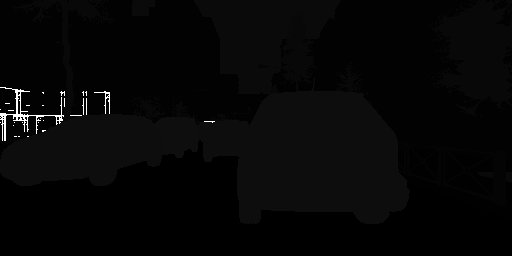

In [26]:
tgt_img = F.to_pil_image(F.to_dtype(tgt, torch.uint8))
tgt_img

In [27]:
tgt_img.size

(512, 256)

In [28]:
np.array(tgt_img)

array([[2, 2, 2, ..., 8, 8, 8],
       [2, 2, 2, ..., 8, 8, 8],
       [2, 2, 2, ..., 8, 8, 8],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

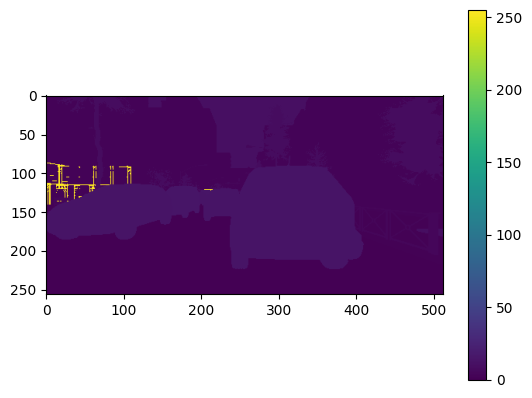

In [29]:
plt.imshow(tgt_img)
plt.colorbar()

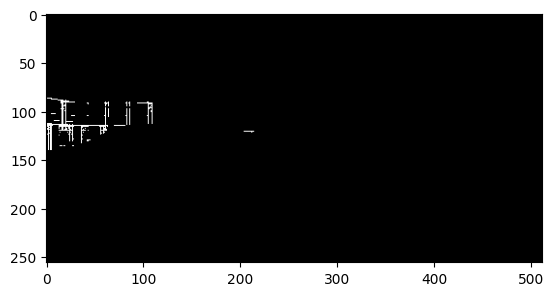

In [30]:
test = np.array(np.array(tgt_img) == 255)
plt.imshow(test, cmap="gray")

**Q2/ Why is the target image dark and what's the bright part? (hint: print the numpy array)**

The target image corresponds to class labels. So the image contains integers representing the class attributed to each pixel. The bright areas on the image correspond to unlabeled pixels (pixel with no specific class associated) that are set to the value 255 by default.

**Q3/ Please study the dataset a bit. What it is about?**



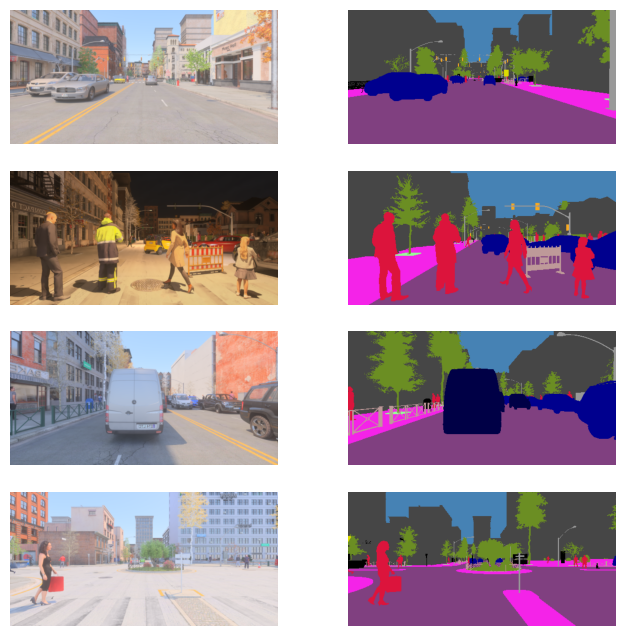

In [31]:
n_images = 4
denormalize = True
segment = True
fig, axs = plt.subplots(n_images, 2, figsize=(8, n_images*2))

for i in range(n_images):
    id = random.randint(0, len(train_set)-1)

    img, target = train_set[id]

    if denormalize:
        mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
        std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
        img = img * std[:, None, None] + mean[:, None, None]
    img = F.to_dtype(img, torch.uint8, scale=True)
    img = F.to_pil_image(img)

    if segment:
        tmp_target = target.masked_fill(target == 255, 21)
        target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
        img_segmented = draw_segmentation_masks(train_set[id][0], target_masks, alpha=1, colors=val_set.color_palette)
        target = F.to_pil_image(img_segmented)
    else:
        target = F.to_dtype(target, torch.uint8, scale=True)
        target = F.to_pil_image(target)

    axs[i,0].imshow(img)
    axs[i,0].axis("off")
    axs[i,1].imshow(target)
    axs[i,1].axis("off")

This dataset contains pair of images. The first image correponds to photos from a camera fixed at the front of a car in different situations. It seems that the environments in which the car evolves are mostly cities (roads, buildings, pedestrians, cars, trees...). The second "image" contains the label of each pixel from the first image: a single value is attributed to all pixels that are part of an object (roads, buildings, pedestrians, cars, trees...). If an object is not in the predefined list of recognized object a default value is attributed.

In [32]:
train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers)

val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers)

test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers)

In [33]:
def enet_weighing(dataloader, num_classes, c=1.02):
    """Computes class weights as described in the ENet paper.

        w_class = 1 / (ln(c + p_class)),

    where c is usually 1.02 and p_class is the propensity score of that
    class:

        propensity_score = freq_class / total_pixels.

    References:
        https://arxiv.org/abs/1606.02147

    Args:
        dataloader (``data.Dataloader``): A data loader to iterate over the
            dataset.
        num_classes (``int``): The number of classes.
        c (``int``, optional): AN additional hyper-parameter which restricts
            the interval of values for the weights. Default: 1.02.

    """
    class_count = 0
    total = 0
    for _, label in dataloader:
        label = label.cpu().numpy()
        # Flatten label
        flat_label = label.flatten()
        flat_label = flat_label[flat_label != 255]

        # Sum up the number of pixels of each class and the total pixel
        # counts for each label
        class_count += np.bincount(flat_label, minlength=num_classes)
        total += flat_label.size

    # Compute propensity score and then the weights for each class
    propensity_score = class_count / total
    return 1 / (np.log(c + propensity_score))

In [35]:
print("Computing class weights...")
print("(this can take a while depending on the dataset size)")
class_weights = enet_weighing(train_loader, 22)
# class_weights = torch.from_numpy(class_weights).float().cuda()
class_weights = torch.from_numpy(class_weights).float()
print("Class weights:", class_weights)

Computing class weights...
(this can take a while depending on the dataset size)
Class weights: tensor([ 4.1643, 18.8984,  3.2313, 48.7521, 34.9159, 33.8659, 46.7701, 49.3670,
        12.2677, 48.3328, 14.2019, 32.0444, 50.4983,  5.2256, 21.1894, 50.4983,
        50.4983, 50.4983, 50.4983, 50.4983, 50.4983, 50.4983])


In [36]:
for i, muad_class in enumerate(train_set.classes[:19]):
    class_name = muad_class.name
    train_id = muad_class.id
    print(f"Class: {class_name:20} | Train ID: {train_id:2} | Weight: {class_weights[i]}")

Class: road                                | Train ID:  0 | Weight: 4.164276123046875
Class: sidewalk                            | Train ID:  1 | Weight: 18.89836311340332
Class: building                            | Train ID:  2 | Weight: 3.2313344478607178
Class: wall                                | Train ID:  3 | Weight: 48.7520751953125
Class: fence                               | Train ID:  4 | Weight: 34.915931701660156
Class: pole                                | Train ID:  5 | Weight: 33.86589813232422
Class: traffic_light                       | Train ID:  6 | Weight: 46.77009582519531
Class: traffic_sign                        | Train ID:  7 | Weight: 49.36697769165039
Class: vegetation                          | Train ID:  8 | Weight: 12.267683982849121
Class: terrain                             | Train ID:  9 | Weight: 48.332786560058594
Class: sky                                 | Train ID: 10 | Weight: 14.20185661315918
Class: person                              | Train 

The weight attributed to each class seems coherent. Very frequent classes like road (that take a lot of space on the images) have a small weight whereas less frequent classes have a higher weight.

**Q4/ Why do we need to evaluate the class_weights?**

Notice that the more the class is frequent, the smaller its weight is. These weights are used to balance classes in the dataset. For instance, in the dataset there are way more pixels of road than pixels of trees. Without using class weights to balance classes, the model might learn not to predict classes that are less probable/represented in the data because they do not impact the loss a lot. In the worst case scenario: the model learns to predict only the most frequent class in the dataset because it is the correct prediction most of the times...

## C. building the DNN

In [37]:
class DoubleConv(nn.Module):
    """(conv => BN => ReLU) * 2."""

    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.mpconv(x)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super().__init__()
        self.bilinear = bilinear

        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        if self.bilinear:
            x1 = F.resize(x1, size=[2*x1.size()[2],2*x1.size()[3]],
                          interpolation=v2.InterpolationMode.BILINEAR)
        else:
            x1 = self.up(x1)

        # input is CHW
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    # Please note that we have added dropout layer to be abble to use MC dropout
    def __init__(self, classes):
        super().__init__()
        self.inc = InConv(3, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128)
        self.up2 = Up(256, 64)
        self.up3 = Up(128, 32)
        self.up4 = Up(64, 32)
        self.dropout = nn.Dropout2d(0.1)
        self.outc = OutConv(32, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.dropout(x)
        x = self.up2(x, x3)
        x = self.dropout(x)
        x = self.up3(x, x2)
        x = self.dropout(x)
        x = self.up4(x, x1)
        x = self.dropout(x)
        return self.outc(x)

**Q5/ Do we really use U-Net? What did I change? (that is hard)**

The architecture looks very similar from the original U-Net architecture proposed in [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597). However there are some small differences. The number of channels in not the same (generally half of what was originally proposed). According to the same paper, there is no batch normalisation. The comment in the code snippet says dropout layers are only here to use Monte-Carlo dropout for model uncertainty evaluation.

**Q6/Do we need a backbone with U-Net?**

With U-Net using a backbone is not necessary. However, it is possible to use a backbone for the encoder part to improve the overall model performance. No backbone is used in this practical work, the U-Net model is trained from scratch.

## D. Utility functions

In [38]:
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_accu(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training MIoU", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation MIoU", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.legend(loc="upper right")
    plt.title("Evolution of MIoU")
    plt.show()

**Q7/ What is the IoU?**

IoU stands for Intersection over Union, which is a metric commonly used to evaluate the performance of object detection models. It measures the overlap between two bounding boxes: the predicted bounding box (from the model) and the ground truth bounding box (the actual object location).


### Training function

**Q8/ Please complete the training and the test function**

In [39]:
def train(model, data_loader, optim, criterion, metric, iteration_loss=False):
    model.train()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()

        # Forward propagation
        logits = model(img)
        flatten_logits = rearrange(logits, "b c h w -> (b h w) c")
        flatten_labels = labels.flatten()

        valid_mask = flatten_labels != 255

        # Loss computation
        loss = criterion(flatten_logits[valid_mask], flatten_labels[valid_mask])

        # Backpropagation
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of the evaluation metric
        metric.update(flatten_logits[valid_mask].detach(), flatten_labels[valid_mask].detach())

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute().item()

### Validation function

In [40]:
def test(model, data_loader, criterion, metric, iteration_loss=False):
    model.eval()
    epoch_loss = 0.0
    metric.reset()
    for step, batch_data in enumerate(data_loader):
        # Get the inputs and labels
        img = batch_data[0].cuda()
        labels = batch_data[1].cuda()

        with torch.no_grad():
            # Forward propagation
            logits = model(img)
            flatten_logits = rearrange(logits, "b c h w -> (b h w) c")
            flatten_labels = labels.flatten()

            valid_mask = flatten_labels != 255

            # Loss computation
            loss = criterion(flatten_logits[valid_mask], flatten_labels[valid_mask])

        # Keep track of loss for current epoch
        epoch_loss += loss.item()

        # Keep track of evaluation the metric
        metric.update(flatten_logits[valid_mask], flatten_labels[valid_mask])

        if iteration_loss:
            print("[Step: %d] Iteration loss: %.4f" % (step, loss.item()))

    # Compute IoU per class
    tp, fp, _, fn = metric._final_state()
    iou_per_class = _safe_divide(tp, tp + fp + fn, zero_division=float("nan"))

    return epoch_loss / len(data_loader), iou_per_class, metric.compute().item()

## E. Training Process

**Q9/ Please train your DNN and comment**



In [41]:
%%script false --no-raise-error
def save_checkpoint(
        checkpoint, is_best, path="checkpoint.pth.tar",
        best_path="checkpoint_best.pth.tar"):
    torch.save(checkpoint, path)
    if is_best:
        shutil.copyfile(path, best_path)

# Intialize U-Net
n_classes = 22
net = UNet(n_classes).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_decay_epochs, gamma=lr_decay)
# We are going to use the CrossEntropyLoss loss function as it's most
# frequentely used in classification problems with multiple classes which
# fits the problem. This criterion combines LogSoftMax and NLLLoss.
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
metric = MeanIntersectionOverUnion(n_classes).to(device) # ignore_index=21???

# Run training and track with wandb
train_loss_history = []
val_loss_history = []
train_miou_history = []
val_miou_history = []
best_loss = float("inf") # Best loss
# nb_epochs = 2 # FOR TESTING PURPOSE ONLY
for epoch in range(1, nb_epochs+1):
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

    # Train one epoch
    train_loss, iou_per_class, train_metric = train(net, train_loader, optimizer, criterion, metric, iteration_loss=False)
    train_loss_history.append(train_loss)
    train_miou_history.append(train_metric)

    # Validation
    val_loss, iou_per_class, val_metric = test(net, val_loader, criterion, metric, iteration_loss=False)
    val_loss_history.append(val_loss)
    val_miou_history.append(val_metric)

    # Learning rate scheduler step
    lr_scheduler.step(val_loss)

    # Save model
    is_best = val_loss < best_loss
    best_loss = min(val_loss, best_loss)
    save_checkpoint(net.state_dict(), is_best)

    # Logging
    if (epoch % 10) == 0:
        print(
            f"[Epoch {epoch:2}/{nb_epochs}]"
            f"Train: loss={train_loss:.3f}, metric={train_metric:.3f} |"
            f"Validation: loss={val_loss:.3f}, metric={val_metric:.3f}"
        )

# Save model
torch.save(net.state_dict(), "model.pth")

In [42]:
# Loading a model
n_classes = 22
model = UNet(n_classes)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
metric = MeanIntersectionOverUnion(n_classes).to(device) # ignore_index=21???
model.load_state_dict(torch.load("model.pth", weights_only=True))
model = model.eval().to(device)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

# III. Evalution of the Trained DNN on the test

## A. classical evaluations

In [ ]:
with open("train_loss_history.txt", "r") as f:
    train_loss_history = json.loads(f.read())
with open("val_loss_history.txt", "r") as f:
    val_loss_history = json.loads(f.read())
with open("train_miou_history.txt", "r") as f:
    train_miou_history = json.loads(f.read())
with open("val_miou_history.txt", "r") as f:
    val_miou_history = json.loads(f.read())

In [ ]:
plot_losses(train_loss_history, val_loss_history)

In [ ]:
plot_accu(train_miou_history, val_miou_history)

**Q10/ Please plot the loss and MIoU. Comment.**

Both the training and test loss curves show a similar downward trend, stabilizing around 0.3. However, there's a notable difference in the mean Intersection over Union (mIoU) values: the training mIoU reaches approximately 0.75, whereas the test mIoU plateaus at around 0.65. This discrepancy indicates a definite overfitting to the training dataset.

**Q11/ What should we have done to avoid overfitting?**

Overfitting often occurs when the model has too few training examples. One solution to avoid overfitting could be to train the model on more data either by increasing the dataset size with new real samples or by using data augmentation techniques such as applying linear transformation (like shift, rotatation or flip) to images for instance. Other techniques such as color shifting or adding noise might cause issue in the context of autonomous driving.

Regularisation is also a good way to avoid overfitting. It can be viewed as simplifying the model in a random way and smaller models are less prone to overfitting.

Early stopping is also a great idea. In this case, it could be use to stop the training as soon as the loss stabilises. However, one downside of early stopping is that any potential loss drop is out of reach (reaching a new local minimum after a couple of epochs).

In [ ]:
# Now we evaluate the model on all the test set.
loss, iou, miou = test(model, test_loader, criterion, metric)
print(f"[FINAL TEST] loss={loss} | metric={miou}")
# Print per class IoU on last epoch or if best iou
for muad_class, class_iou in zip(test_set.classes, iou, strict=True):
    print(f"[{muad_class.id}] {muad_class.name}: {class_iou:.4f}")

## B. Uncertainty evaluations with MCP
Here you will just use as confidence score the Maximum class probability (MCP)


In [ ]:
sample_idx = 0
img, target = test_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]
pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Q12/ The last image is the related to the confidence score of the DNN. Can you explain why? What does the birght areas represent and what does the dark areas represent?**

From left to right, the first image is the input image and the second image is the target, that is to say the input image perfectly segmented. The third image represents the segmentation made by the model. For now, with only 2 training epochs, this result is very bad. The model did not notice the fence on the road nor did it notice any pedestrian. Only part of the car and of the road are correctly classified as well as some trees. On then last image, we can see the level of confidence of the model or in other words the probability with which it classify each pixel to its class. The brigth areas corresponds to areas where the model is very confident and dark areas represents low confidence. With the current model, the areas with the most confidence are the trees in the background, maybe not the most useful for autonomous driving...

### Now let's load the OOD test set

In [ ]:
test_ood_set = MUAD(root="./data", target_type="semantic", version="small", split="ood" , transforms=val_transform, download=True)
test_ood_set

In [ ]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]
pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Q12 bis/ According to the output, is the model confident when it comes to labeling the bear and goat? How about the bench?**

**Q12 ter/ The last image is the related to the confidence score of the DNN. Can you explain why? Are you happy with this image?**

With 2 training epochs, the DNN is not confident on anything but the trees... However, I expect a better trained model to be very confident on the bench classified as bench but also confident on the bear and goat classified as undefined because there were none of these in the training set.

Need to train the model for longer...

## C. Uncertainty evaluations with Temperature Scaling

**Q13/ Please implement a temperature scaling using torch_uncertainty**

Before Temprature scaling

In [ ]:
# Initialize the calibration dataset
from torch.utils.data import random_split, DataLoader

cal_dataset, test_dataset_bis, other = random_split(
    test_set, [50, 50, len(test_set) - 100]
)

num_classes = 19

test_loader_bis = DataLoader(test_dataset_bis, batch_size=batch_size)

In [ ]:
# https://github.com/ENSTA-U2IS-AI/torch-uncertainty/blob/main/auto_tutorials_source/tutorial_scaler.py
from torch_uncertainty.metrics import CalibrationError

# Initialize the ECE
ece = CalibrationError(task="multiclass", num_classes=num_classes).cuda()

# Iterate on the calibration dataloader
for sample, target in test_loader_bis:
    logits = model(sample.cuda())

    # the channel dimension for the target need to be removed, unless we get a ValueError ('The `preds` and `target` should have the same shape')
    flatten_logits =  rearrange(logits, 'b c h w -> (b h w) c')
    flatten_target = rearrange(target, 'b c h w -> (b c h w)')

    #not sure we are supposed to use the validation mask here
    valid_mask = flatten_target != 255
    target = flatten_target[valid_mask]
    flatten_logits = flatten_logits[valid_mask]

    probs = flatten_logits.softmax(1)
    ece.update(probs, target.cuda())

# Compute & print the calibration error
print(f"ECE before scaling - {ece.compute():.3%}.")

In [ ]:
# Plot the top-label calibration figure
fig, ax = ece.plot()
fig.show()

**Q13 bis/ Seeing the two graphs above comment on the MCP unceratinty result, is the model overconfident or calibrated ?**

After temperature scaling

In [ ]:
from torch_uncertainty.post_processing import TemperatureScaler
from tqdm import tqdm
from torch.utils.data import DataLoader

# modify fit call from class Scaler
# https://github.com/ENSTA-U2IS-AI/torch-uncertainty/blob/7d0d345a44ac6ada38372bc6dbce007a00cfeeb5/torch_uncertainty/post_processing/calibration/scaler.py#L12

def fit_adaptation(self, calibration_set, save_logits=False, progress=True):
  logits_list = []
  labels_list = []
  calibration_dl = DataLoader(calibration_set, batch_size=32, shuffle=False, drop_last=False)

  with torch.no_grad():
    for inputs, labels in tqdm(calibration_dl, disable=not progress):
      logits = self.model(inputs.to(self.device))

      flatten_logits =  rearrange(logits, 'b c h w -> (b h w) c')
      flatten_labels = rearrange(labels, 'b c h w -> (b c h w)')

      valid_mask = flatten_labels != 255
      labels = flatten_labels[valid_mask]
      flatten_logits = flatten_logits[valid_mask]

      logits_list.append(flatten_logits)
      labels_list.append(labels)

  all_logits = torch.cat(logits_list).detach().to(self.device)
  all_labels = torch.cat(labels_list).detach().to(self.device)

  optimizer = torch.optim.LBFGS(self.temperature, lr=self.lr, max_iter=self.max_iter)

  def calib_eval():
    optimizer.zero_grad()
    loss = self.criterion(self._scale(all_logits), all_labels)
    loss.backward()
    return loss

  optimizer.step(calib_eval)
  self.trained = True

  if save_logits:
    self.logits = all_logits
    self.labels = all_labels

TemperatureScaler.fit = fit_adaptation

In [ ]:
# Fit the scaler on the calibration dataset
scaled_model = TemperatureScaler(model=model, device="cuda")

scaled_model.train()
scaled_model.fit(calibration_set=cal_dataset)

In [ ]:
# Reset the ECE
ece.reset()

# Iterate on the calibration dataloader
for sample, target in test_loader_bis:
    logits = scaled_model(sample.cuda())

    flatten_logits =  rearrange(logits, 'b c h w -> (b h w) c')
    flatten_target = rearrange(target, 'b c h w -> (b c h w)')

    valid_mask = flatten_target != 255
    target = flatten_target[valid_mask]
    flatten_logits = flatten_logits[valid_mask]

    probs = flatten_logits.softmax(-1)

    ece.update(probs, target.cuda())

# Compute & print the calibration error
print(f"ECE after scaling - {ece.compute():.3%}.")

In [ ]:
# Plot the top-label calibration figure
fig, ax = ece.plot()
fig.show()

Now let's see the new confidence score image after scaling

In [ ]:
sample_idx = 0
img, target = test_ood_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
scaled_model.eval()
with torch.no_grad():
	# Forward propagation
	outputs = scaled_model(batch_img)
	outputs_proba = outputs.softmax(dim=1)
	# remove the batch dimension
	outputs_proba = outputs_proba.squeeze(0)
	confidence, pred = outputs_proba.max(0)

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]

pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Q13 ter/ Did the model get more confident? Is it more calibrated? Comment on the temperature scaling graphs and results.**

## D. Uncertainty evaluations with MC Dropout

Let us implement **MC dropout**. This technique decribed in [this paper](https://arxiv.org/abs/1506.02142) allow us to have a better confindence score by using the dropout during test time.



**Q14/ Please implement MC Dropout using torch_uncertainty**

In [ ]:
# https://github.com/ENSTA-U2IS-AI/torch-uncertainty/blob/main/auto_tutorials_source/tutorial_mc_dropout.py
from torch_uncertainty.models.wrappers.mc_dropout import mc_dropout
from torch_uncertainty.routines import ClassificationRoutine
from torch_uncertainty import TUTrainer

mc_model = mc_dropout(model, num_estimators=16, last_layer=False).cuda()

routine = ClassificationRoutine(
    num_classes=n_classes,
    model=mc_model,
    loss=nn.CrossEntropyLoss(),
    # optim_recipe=optim_cifar10_resnet18(mc_model), # ???
    is_ensemble=True,
)

trainer = TUTrainer(accelerator="gpu", max_epochs=2, enable_progress_bar=False)
trainer.fit(model=routine, datamodule=train_loader)
results = trainer.test(model=routine, datamodule=test_loader)

In [ ]:
mc_model_path = "mc.pth"
torch.save(ens_model.state_dict(), mc_model_path)
print(f"Model saved to {mc_model_path}")

In [ ]:
sample_idx = 0
img, target = test_set[sample_idx]

batch_img = img.unsqueeze(0).cuda()
batch_target = target.unsqueeze(0).cuda()
mc_model.eval()
with torch.no_grad():
    # Forward propagation
    outputs = mc_model(batch_img)
    outputs_proba = outputs.softmax(dim=1)
    # remove the batch dimension
    outputs_proba = outputs_proba.squeeze(0)
    max_outputs_proba, _ = outputs_proba.max(1)
    confidence, pred = max_outputs_proba.max(0)

In [ ]:
# Undo normalization on the image and convert to uint8.
mean = torch.tensor([0.485, 0.456, 0.406], device=img.device)
std = torch.tensor([0.229, 0.224, 0.225], device=img.device)
img = img * std[:, None, None] + mean[:, None, None]
img = F.to_dtype(img, torch.uint8, scale=True)

tmp_target = target.masked_fill(target == 255, 21)
target_masks = tmp_target == torch.arange(22, device=target.device)[:, None, None]
img_segmented = draw_segmentation_masks(img, target_masks, alpha=1, colors=test_set.color_palette)

pred_masks = pred == torch.arange(22, device=pred.device)[:, None, None]
pred_img = draw_segmentation_masks(img, pred_masks, alpha=1, colors=test_set.color_palette)

img_pil = F.to_pil_image(img)
img_segmented = F.to_pil_image(img_segmented)
confidence_img = F.to_pil_image(confidence)
pred_img = F.to_pil_image(pred_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 15))
ax1.imshow(img_pil)
ax2.imshow(img_segmented)
ax3.imshow(pred_img)
ax4.imshow(confidence_img)
plt.show()

**Q14 bis/ Try the MC dropout code with a low number of estimators T like 3 and a high number 20, Explain the diffrence seen on the confidence image, is the model getting more confident or less ?**

## E. Uncertainty evaluations with Deep Ensembles

**Q15/ Please implement [Deep Ensembles](https://papers.nips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf).**


1.   You need to train 3 DNNs and save it. (Go back to the training cell above and train and save 3 diffrent models)
2.   Use TorchUncertainty to get predictions

You have two options either train several models using the code above or use TU to train the ensemble of models in parallel.

In [ ]:
from torch_uncertainty.models import deep_ensembles
from torch_uncertainty.routines import ClassificationRoutine
from torch_uncertainty import TUTrainer

ens_model = deep_ensembles(model, num_estimators=16).cuda()

ens_routine = ClassificationRoutine(
    num_classes=n_classes,
    model=ens_model,
    loss=nn.CrossEntropyLoss(),
    # optim_recipe=optim_cifar10_resnet18(mc_model), # ???
    is_ensemble=True,
)

ens_trainer = TUTrainer(accelerator="gpu", max_epochs=2, enable_progress_bar=False)
ens_trainer.fit(model=ens_routine, datamodule=train_loader)
results = trainer.test(ens_routine, test_loader)

Save the ensemble model.

In [ ]:
ens_model_path = "ensemble.pth"
torch.save(ens_model.state_dict(), ens_model_path)
print(f"Model saved to {ens_model_path}")

## F. Uncertainty evaluations with Packed-Ensembles

**Q16/ Please read [Packed-Ensembles](https://arxiv.org/pdf/2210.09184). Then Implement a Packed-Ensembles Unet and train it and evaluate its Uncertainty.**


**Please conclude your report.**